In [7]:
df['match_id'].values.tolist()

[3215497967,
 3215097220,
 3215312675,
 3215162338,
 3215181105,
 3215377994,
 3215271631,
 3215289100,
 3215279863,
 3215253055,
 3215448302,
 3215416370,
 3215261563,
 3215294948,
 3215155134,
 3215350255,
 3215341221,
 3215306187,
 3215302636,
 3215316820,
 3215190109,
 3215355847,
 3215130854,
 3215259897,
 3215394671,
 3215152225,
 3215274711,
 3215366609,
 3215449992,
 3215376405,
 3215268540,
 3215420902,
 3215332931,
 3215327547,
 3215354992,
 3215254939,
 3215149372,
 3215370025,
 3215201012,
 3215272070,
 3215223639,
 3215422492,
 3215260456,
 3215354934,
 3215377592,
 3215445972,
 3215101148,
 3215174827,
 3215384305,
 3215188370,
 3215297782,
 3215493515,
 3215119808,
 3215360521,
 3215102154,
 3215271055,
 3215403667,
 3215217460,
 3215482564,
 3215466626,
 3215255292,
 3215095789,
 3215108689,
 3215330831,
 3215468550,
 3215446132,
 3215384555,
 3215470445,
 3215318005,
 3215238829,
 3215293087,
 3215391855,
 3215439074,
 3215401870,
 3215440922,
 3215092973,
 3215369622,

In [8]:
df['residual'].values.tolist()

[60.09383010864258,
 22.98058319091797,
 14.018461227416992,
 12.276541709899902,
 10.960655212402344,
 10.190336227416992,
 9.797115325927734,
 8.665862083435059,
 8.291083335876465,
 6.753566265106201,
 5.982767105102539,
 5.009283542633057,
 4.787799835205078,
 4.737585544586182,
 4.151325702667236,
 3.8586721420288086,
 3.7200565338134766,
 3.653451919555664,
 3.6120126247406006,
 3.55796217918396,
 3.5249321460723877,
 3.4550528526306152,
 3.4301578998565674,
 2.9261271953582764,
 2.8132457733154297,
 2.767648220062256,
 2.758488178253174,
 2.543581247329712,
 2.5158803462982178,
 2.4831578731536865,
 2.4762089252471924,
 2.392141342163086,
 2.38230299949646,
 2.3297765254974365,
 2.2398288249969482,
 2.229811429977417,
 2.1894421577453613,
 2.1700241565704346,
 2.150897741317749,
 2.0817346572875977,
 2.0602142810821533,
 2.044538974761963,
 2.038116693496704,
 2.0010886192321777,
 1.953024983406067,
 1.9425238370895386,
 1.919196367263794,
 1.8698474168777466,
 1.823149442672729

In [39]:
percentile99 = np.percentile(df['residual'], 99)

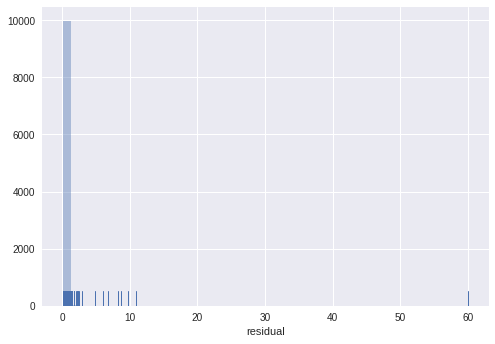

In [10]:
sns.distplot(df['residual'].sample(n=10000),  kde=False, rug=True)
plt.show()

In [11]:
len(df)

42798

In [12]:
plt.close()

In [13]:
residuals = df['residual'].values.tolist()

In [14]:
np.max(residuals) - np.min(residuals)

60.033355519175529

In [15]:
df['residual']

34387    60.093830
29487    22.980583
9093     14.018461
3126     12.276542
18042    10.960655
31544    10.190336
12902     9.797115
35763     8.665862
24034     8.291083
2997      6.753566
40736     5.982767
17228     5.009284
3951      4.787800
17480     4.737586
29643     4.151326
32080     3.858672
20749     3.720057
20553     3.653452
39536     3.612013
33550     3.557962
19093     3.524932
41758     3.455053
21307     3.430158
3626      2.926127
37586     2.813246
1932      2.767648
19951     2.758488
33785     2.543581
41588     2.515880
33449     2.483158
           ...    
26745     0.069483
6663      0.069253
33089     0.069227
9142      0.069197
8351      0.069074
11067     0.069049
12730     0.068937
36159     0.068805
26505     0.068641
39416     0.068497
31856     0.068060
30284     0.067955
5200      0.067766
2822      0.067643
21654     0.067419
2817      0.066208
31155     0.065560
41445     0.065004
1467      0.064927
15025     0.064823
41066     0.064179
27139     0.

In [16]:
def RadiantDireDifference(row, column):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    radiantSum = 0
    direSum = 0
    for pos in poss:
        radiantSum += row['radiant_'+ pos + '_' + column]
        direSum += row['dire_'+ pos + '_' + column]
    return radiantSum - direSum

def reject_outliers(data, m=1.5):
    return abs(data - np.mean(data)) < m * np.std(data)


def heroKDAdeficit(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_kills'] + \
                        row[fac + '_' + pos + '_assists'] - \
                        row[fac + '_' + pos + '_deaths']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = value
    return returnVal

def heroKDdeficit(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_kills'] - \
                        row[fac + '_' + pos + '_deaths']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = value
    return returnVal

def heroKD(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_kills'] - \
                        row[fac + '_' + pos + '_deaths']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = int(pos[3:4])
    return returnVal

def heroGoldSpent(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_gold_spent']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = int(pos[3:4])
    return returnVal

In [47]:
def outlier_mask(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return s<m

In [ ]:
df_graph 

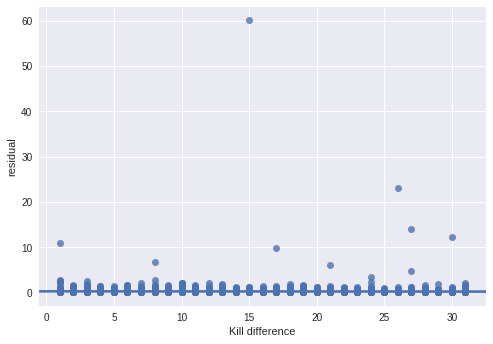

In [49]:
kill_difference = np.abs(df.apply(RadiantDireDifference, args=('kills',), axis=1))
sns.regplot(kill_difference[kill_difference_mask], df['residual'][kill_difference_mask])
ax = plt.gca()
ax.set_xlabel("Kill difference")
plt.show()

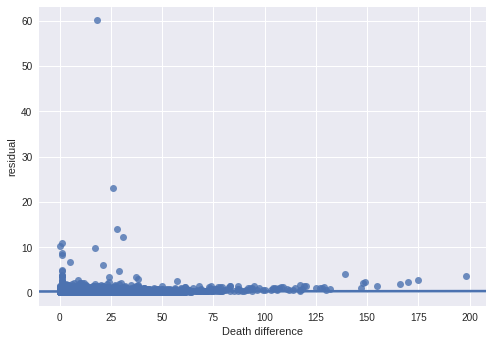

In [18]:
death_difference = df.apply(RadiantDireDifference, args=('deaths',), axis=1)
sns.regplot(np.abs(death_difference), df['residual'])
ax = plt.gca()
ax.set_xlabel("Death difference")
plt.show()

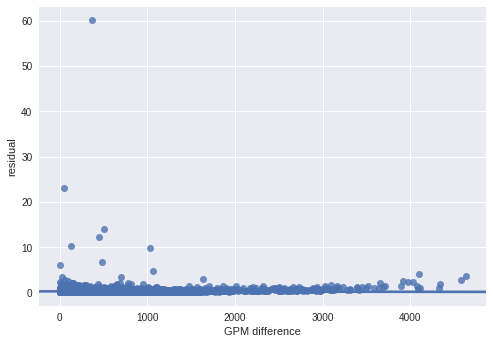

In [19]:
gold_difference = df.apply(RadiantDireDifference, args=('gpm',), axis=1)
above_ = np.abs(gold_difference) <= 5000

indices = np.where(above_)[0]
sns.regplot(np.abs(gold_difference)[above_], df['residual'].iloc[indices])
ax = plt.gca()
ax.set_xlabel("GPM difference")
plt.show()

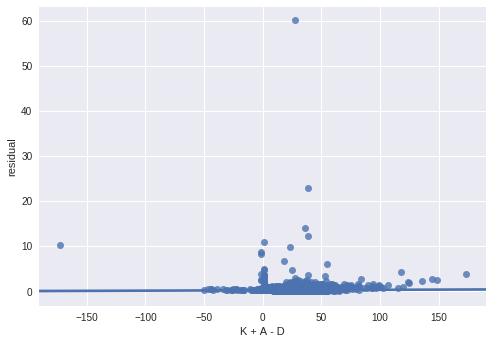

In [20]:
kda = df.apply(heroKDAdeficit, axis=1)
sns.regplot(kda, df['residual'])
ax = plt.gca()
ax.set_xlabel("K + A - D")
plt.show()

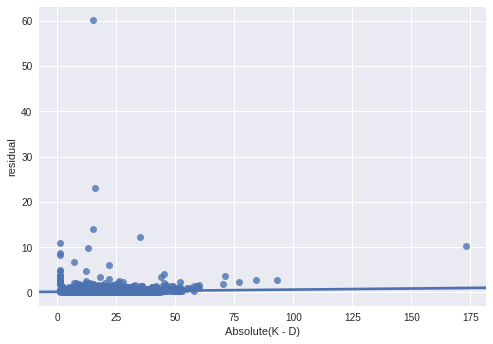

In [21]:
kd = df.apply(heroKDdeficit, axis=1)
sns.regplot(np.abs(kd), df['residual'])
ax = plt.gca()
ax.set_xlabel("Absolute(K - D)")
plt.show()

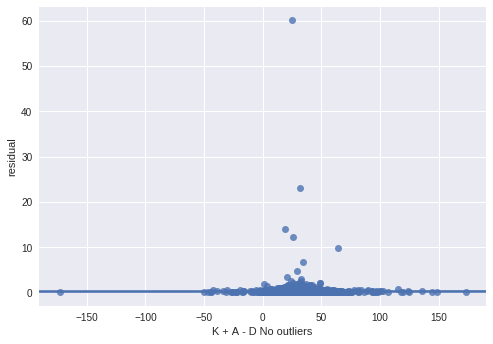

In [22]:
kda = df.apply(heroKDAdeficit, axis=1)
kda_mean = np.mean(kda)
kda_std = np.std(kda)
indices = np.where(np.logical_and(kda <= kda_mean + 1.5*kda_std, kda >= kda_mean-1.5*kda_std))[0]
sns.regplot(kda[indices], df['residual'].iloc[indices])
ax = plt.gca()
ax.set_xlabel("K + A - D No outliers")
plt.show()

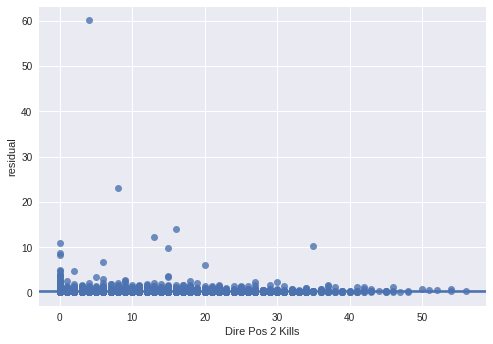

In [23]:
sns.regplot(df['dire_pos2_kills'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Dire Pos 2 Kills")
plt.show()

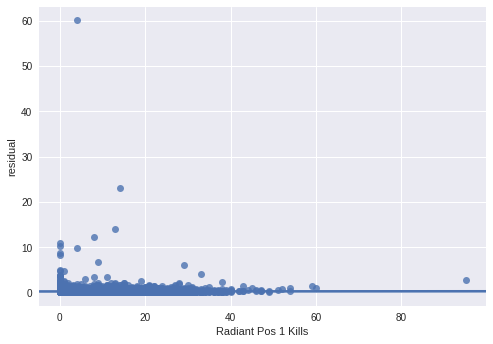

In [24]:
sns.regplot(df['radiant_pos1_kills'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Radiant Pos 1 Kills")
plt.show()

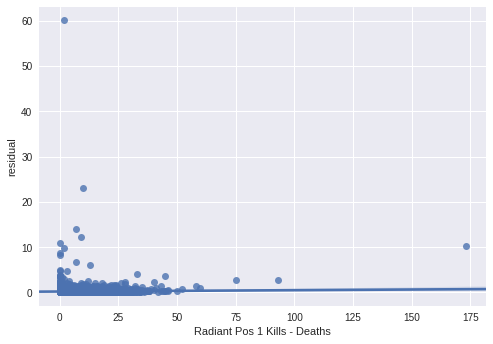

In [25]:
sns.regplot(np.abs(df['radiant_pos1_kills'] - df['radiant_pos1_deaths']), df['residual'])
ax = plt.gca()
ax.set_xlabel("Radiant Pos 1 Kills - Deaths")
plt.show()

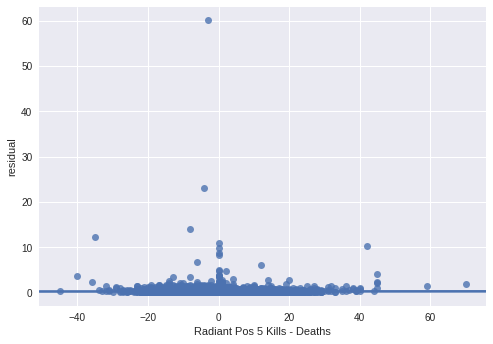

In [26]:
sns.regplot(df['radiant_pos5_kills'] - df['radiant_pos5_deaths'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Radiant Pos 5 Kills - Deaths")
plt.show()

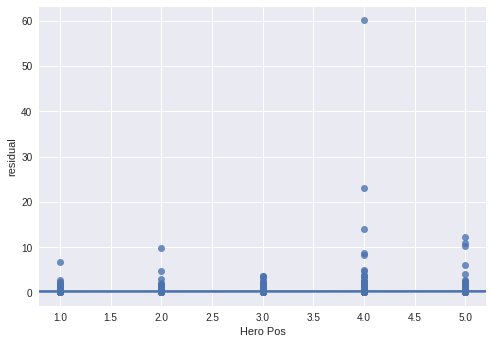

In [27]:
sns.regplot(df.apply(heroKD, axis=1), df['residual'])
ax = plt.gca()
ax.set_xlabel("Hero Pos")
plt.show()

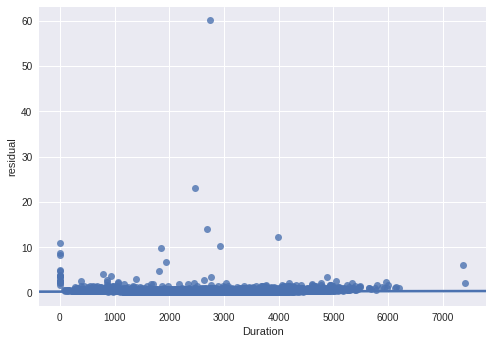

In [28]:
sns.regplot(df['duration'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Duration")
plt.show()

In [40]:
df[df['residual'] > percentile99]

,match_id,positive_votes,negative_votes,first_blood_time,radiant_win,duration,dire_pos1_ancient_kills,dire_pos1_courier_kills,dire_pos1_kills,dire_pos1_neutral_kills,...,dire_pos2_abandons,dire_pos3_abandons,dire_pos4_abandons,dire_pos5_abandons,radiant_pos1_abandons,radiant_pos2_abandons,radiant_pos3_abandons,radiant_pos4_abandons,radiant_pos5_abandons,residual
34387,3215497967,49,2,14,True,2748,43.0,0.0,4,141.0,...,0,0,0,0,0,0,0,0,0,60.093830
29487,3215097220,15,7,15,True,2470,23.0,0.0,7,108.0,...,0,0,0,0,0,0,0,0,0,22.980583
9093,3215312675,9,4,0,False,2687,0.0,0.0,10,9.0,...,0,0,0,0,0,0,0,0,0,14.018461
3126,3215162338,0,0,135,False,3981,18.0,21.0,27,70.0,...,0,0,0,0,0,0,0,0,0,12.276542
18042,3215181105,0,0,0,True,0,NaN,NaN,0,NaN,...,0,0,0,0,0,0,0,1,0,10.960655
31544,3215377994,0,0,72,False,2924,NaN,NaN,28,NaN,...,0,0,0,0,0,0,0,0,0,10.190336
12902,3215271631,7,1,3,False,1846,4.0,0.0,5,36.0,...,0,0,0,0,0,0,0,0,0,9.797115
35763,3215289100,0,0,0,False,0,NaN,NaN,0,NaN,...,0,0,1,0,0,0,0,0,0,8.665862
24034,3215279863,0,0,0,False,0,NaN,NaN,0,NaN,...,0,0,1,0,0,0,0,0,0,8.291083
2997,3215253055,5,0,182,True,1949,0.0,0.0,4,10.0,...,0,0,0,0,0,0,0,0,0,6.753566


In [42]:
df[df['residual'] < percentile99].sample(n=10, random_state=1)

,match_id,positive_votes,negative_votes,first_blood_time,radiant_win,duration,dire_pos1_ancient_kills,dire_pos1_courier_kills,dire_pos1_kills,dire_pos1_neutral_kills,...,dire_pos2_abandons,dire_pos3_abandons,dire_pos4_abandons,dire_pos5_abandons,radiant_pos1_abandons,radiant_pos2_abandons,radiant_pos3_abandons,radiant_pos4_abandons,radiant_pos5_abandons,residual
14282,3215105241,0,0,112,False,2777,NaN,NaN,24,NaN,...,0,0,0,0,0,0,0,0,0,0.174453
15907,3215376151,0,0,114,True,2399,NaN,NaN,7,NaN,...,0,0,0,0,0,0,0,0,0,0.108168
15323,3215415736,0,0,169,False,3833,NaN,NaN,20,NaN,...,0,0,1,0,0,0,0,0,0,0.539407
5998,3215109078,0,0,191,False,3583,1.0,0.0,15,51.0,...,0,0,0,0,0,0,0,0,0,0.522020
11372,3215171445,0,0,106,True,3963,NaN,NaN,14,NaN,...,0,0,0,0,0,0,0,0,0,0.219839
42172,3215172311,1,0,60,True,4322,NaN,NaN,4,NaN,...,0,0,0,0,0,0,0,0,0,0.478943
33681,3215186932,0,0,402,True,2640,NaN,NaN,10,NaN,...,0,0,0,0,0,0,0,0,0,0.108369
16759,3215409668,0,0,179,False,2451,NaN,NaN,9,NaN,...,0,0,0,0,0,0,1,0,0,0.138435
9437,3215384337,0,0,146,True,3289,NaN,NaN,8,NaN,...,0,0,0,0,0,0,1,0,0,0.514544
14204,3215141313,0,0,126,False,2572,3.0,0.0,11,116.0,...,0,0,0,0,0,0,0,0,0,0.341837


In [43]:
biggestAnom = np.loadtxt('data/anomalies.csv', delimiter = ',')
theirOutput = np.loadtxt('data/output.csv', delimiter = ",")

In [44]:
biggestAnom = np.column_stack([df['match_id'].values, biggestAnom])
theirOutput = np.column_stack([df['match_id'].values, theirOutput])

In [45]:
def whichIndex(row1, row2):
    largestError = -1
    index = -1
    for i in range(1, len(row1)):
        if abs(row1[i] - row2[i]) > largestError:
            largestError = abs(row1[i] - row2[i])
            index = i
    return index
columns = list(df.columns)
columns.remove('match_id')
for i in range(len(biggestAnom)):
    index = whichIndex(biggestAnom[i, :], theirOutput[i, :])
    if df.iloc[i]['residual'] >= percentile99:
        print int(biggestAnom[i, 0]), columns[index], biggestAnom[i, index], theirOutput[i, index]

3215497967 negative_votes 49.0 1.0
3215097220 negative_votes 15.0 1.0
3215312675 negative_votes 9.0 1.0
3215162338 dire_pos5_courier_kills 0.997236430645 0.254108220339
3215181105 radiant_pos3_gpm 0.967831552029 0.215277791023
3215377994 dire_pos5_kda 0.986187636852 0.675353765488
3215271631 negative_votes 7.0 1.0
3215289100 dire_pos4_gpm 0.915403366089 0.162800624967
3215279863 dire_pos4_gpm 0.915403366089 0.155206382275
3215253055 negative_votes 5.0 1.0
3215448302 radiant_pos1_sentry_uses 0.977942168713 0.730815529823
3215416370 dire_pos3_gpm 0.0236208867282 0.595808267593
3215261563 radiant_pos3_gpm 0.243853777647 0.536930799484
3215294948 negative_votes 4.0 0.999999940395
3215155134 radiant_pos5_kills 0.996014475822 0.729707717896
3215350255 radiant_pos4_gpm 0.172037020326 0.478152662516
3215341221 radiant_pos1_kpm 0.765351176262 0.473023504019
3215306187 radiant_pos2_gpm 0.796920537949 0.594073414803
3215302636 dire_pos4_gpm 0.995038449764 0.616404891014
3215316820 dire_pos5_gpm 0

KeyboardInterrupt: 